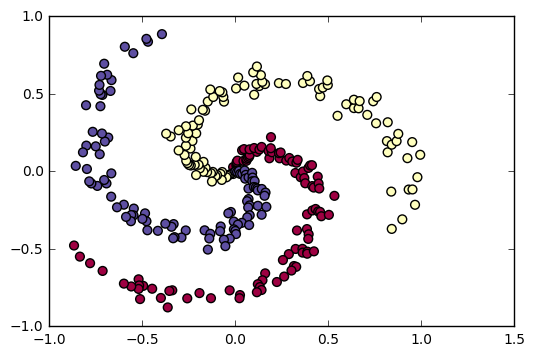

In [1]:
import matplotlib.pyplot as plt
import numpy as np

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

pre_is_loaded = False
mid_is_loaded = False
post_is_loaded = False

In [174]:
from numpy import exp, array, random, dot

class NeuronLayer():
    def __init__(self, inputs, neurons, method=None):
        self.W = 0.01 * np.random.randn(inputs, neurons)
        self.b = np.zeros((1,neurons))
    
        self.W_cache = np.zeros((inputs, neurons))
        self.b_cache = np.zeros((1,neurons))

        self.W_v = np.zeros((inputs, neurons))
        self.W_m = np.zeros((inputs, neurons))        
        self.b_v = np.zeros((1,neurons))
        self.b_m = np.zeros((1,neurons))
        
        if method != None:
            self.method = method.lower()
        else:
            self.method = None

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def sigmoid(self, x):
        return 1. / (1. + exp(-x))

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def dsigmoid(self, x):
        return x * (1. - x)
    
    def calculate(self, x):
        score = np.dot(x, self.W) + self.b
        if self.method == "relu":
            return np.maximum(0, score)
        elif self.method == "sigmoid":
            return self.__sigmoid(score)
        else:
            return score

class NeuralNetwork():
    def __init__(self, layers, params):
        self.layers = layers
        self.params = params

    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations, plot_step=500):
        # some hyperparameters
        step_size = 1e-0
        reg = 1e-3 # regularization strength
        num_examples = len(training_set_outputs)
        mu = 0.5
        loss_ = None
        for iteration in xrange(number_of_training_iterations):
            # Pass the training set through our neural network
            layer_outputs = self.calculate_values(training_set_inputs)
             
            first_layer = True
            layer_idx = len(self.layers) - 1
            
            W_adjustments = []
            b_adjustments = []
            step_sizes = []
            reversed_res = layer_outputs[::-1] 
            reversed_res.append(training_set_inputs)
            result_idx = 1
            arma = -1
            
            for scores in reversed_res[:-1]:

                if first_layer:
                    first_layer = False
                    # print(scores)
                    exp_scores = np.exp(scores)
                    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

                    # compute the loss: average cross-entropy loss and regularization
                    corect_logprobs = -np.log(probs[range(num_examples),training_set_outputs])
                    data_loss = np.sum(corect_logprobs) / num_examples
                    reg_loss = sum(map(lambda x: 0.5*reg*np.sum(x.W*x.W), self.layers))
                    loss = data_loss + reg_loss
                    dscores = probs
                    dscores[range(num_examples), training_set_outputs] -= 1
                    dscores /= num_examples
                    loss_ = loss
                    if (iteration + 1) % plot_step == 0:
                        print("iteration %d: loss %f" % (iteration+1, loss))
                else:
                    step_sizes.append(step_size)
                dW = np.dot(reversed_res[result_idx].T, dscores)
                db = np.sum(dscores, axis=0, keepdims=True)
                dW += reg * self.layers[arma].W
                W_adjustments.append(dW)
                b_adjustments.append(db)
                dscores = np.dot(dscores, self.layers[arma].W.T)
                if not first_layer:
                    dscores[reversed_res[result_idx] <= 0] = 0
                result_idx += 1
                arma -= 1
            for layer, dW, db in zip(self.layers, W_adjustments[::-1], b_adjustments[::-1]):
                #self.update_params(layer.W, dW, layer.W_cache)
                #self.update_params(layer.b, db, layer.b_cache)            
                self.update_params_ADAM(layer.W, dW, layer.W_m, layer.W_v)
                self.update_params_ADAM(layer.b, db, layer.b_m, layer.b_v)
        return loss_

    def update_params_RMSprop(self, x, dx, cache):
        # RMSprop gradient update
        learning_rate = 0.0001
        eps = 1e-4
        decay_rate = 0.95
        cache[:, :] = decay_rate * cache + (1 - decay_rate) * dx**2
        update = -learning_rate * dx / (np.sqrt(cache) + eps)
        param_scale = np.linalg.norm(x.ravel())
        x += update
        
        update_scale = np.linalg.norm(update.ravel())
    
    def update_params_ADAM(self, x, dx, m, v):
        beta1 = self.params["beta1"]
        beta2 = self.params["beta2"]
        eps = self.params["eps"]
        learning_rate = self.params["learning_rate"]
        
        m[:,:] = beta1*m + (1-beta1)*dx
        v[:,:] = beta2*v + (1-beta2)*(dx**2)
        x += - learning_rate * m / (np.sqrt(v) + eps)


        
    # The neural network thinks.
    def calculate_values(self, inputs):
        vals = []
        hidden_layer = inputs
        num_of_layers = len(self.layers)
        for each_layer in self.layers:
            scores = each_layer.calculate(hidden_layer)
            hidden_layer = scores
            vals.append(scores)
        return vals

    def guess(self, inputs):
        return self.calculate_values(inputs)[-1]
            
        

In [167]:
import h5py
import numpy as np
from functools import reduce

def myred(x, y):
    return np.vstack([x, y])

if not pre_is_loaded:
    pre_is_loaded = True
    h5f = h5py.File('data_pre.h5','r')
    len_vals = len(h5f.keys()) / 2
    print(len_vals)

    all_ = [np.array(h5f["datasetpre_{0}".format(x)]) for x in range(len_vals)]
    all_moves = [np.array(h5f["datasetpremove_{0}".format(x)]) for x in range(len_vals)]


    all_vals = reduce(myred, all_)
    all_moves = np.concatenate(all_moves)
    all_moves = all_moves.astype(np.int64)

pit, lev = all_vals.shape
all_idx = np.arange(pit)
np.random.shuffle(all_idx)
nsamples = 10000


cut_pre_vals  = all_vals[all_idx[:nsamples], :]
cut_pre_moves = all_moves[all_idx[:nsamples]]

cut_test_pre_vals  = all_vals[all_idx[nsamples:(nsamples+10000)], :]
cut_test_pre_moves = all_moves[all_idx[nsamples:(nsamples+10000)]]

In [ ]:
D = 363 # dimensionality
h = 100
K=5

# Train the neural network using the training set.
# Do it 60,000 times and make small adjustments each time.
# neural_network_2.train(cut_pre_vals, cut_pre_moves, 5500, plot_step=500)
nets = []
for each in range(150):
    vals = {"beta1": np.random.uniform(0.5, 1.0),
            "beta2":  np.random.uniform(0.5, 1.0),
            "eps":  np.random.uniform(1e-7, 1e-9),
            "learning_rate":  np.random.uniform(1e-2, 0.1)
           }
    layer1 = NeuronLayer(D, h, method="ReLU")

    # Create layer 1 (100 neurons, each with 2 inputs)
    layer2 = NeuronLayer(h, K)

    layers = [layer1, layer2]
    nets.append(NeuralNetwork(layers, vals))

min_loss=1e6
min_idx = 0
print("Searching hyperparameters")
for idx, each in enumerate(nets):
    loss = each.train(cut_pre_vals, cut_pre_moves, 501, plot_step=510)
    if loss < min_loss:
        min_loss = loss
        min_idx = idx
        if (idx +1 ) % 15 == 0:
            ps = each.params
            print("Current minimum: {0} with loss {1} and params {2}".format(idx, min_idx, min_loss, ps))
optimum_network = nets[min_idx]
optimum_network.train(cut_pre_vals, cut_pre_moves, 6000, plot_step=500)

In [171]:
optimum_network = nets[30]
optimum_network.train(cut_pre_vals, cut_pre_moves, 6000, plot_step=500)

iteration 499: loss 0.296371
iteration 999: loss 0.288252
iteration 1499: loss 0.282045
iteration 1999: loss 0.281093
iteration 2499: loss 0.282875
iteration 2999: loss 0.277486
iteration 3499: loss 0.278833
iteration 3999: loss 0.279674
iteration 4499: loss 0.277284
iteration 4999: loss 0.281787
iteration 5499: loss 0.279422
iteration 5999: loss 0.277937


0.27793656835088704

In [183]:
oikein = sum(np.argmax(optimum_network.guess(cut_pre_vals), 1) == cut_pre_moves) / float(len(cut_pre_moves)) * 100.
print("Pre-game sovitettuun dataan {0:.2f}%".format(oikein))

oikein = sum(np.argmax(optimum_network.guess(cut_test_pre_vals), 1) == cut_test_pre_moves) / float(len(cut_test_pre_moves)) * 100.
print("Pre-game testi dataan:      {0:.2f}%".format(oikein))

Pre-game sovitettuun dataan 97.89%
Pre-game testi dataan:      86.09%


In [184]:
with h5py.File('neuro_pre.h5','w') as h5f:
    for i, each in enumerate(optimum_network.layers):
        nimi_W = "W_{0}".format(i)
        h5f[nimi_W] = each.W

        nimi_b = "b_{0}".format(i)
        h5f[nimi_b] = each.b

In [176]:
import h5py
import numpy as np
from functools import reduce

def myred(x, y):
    return np.vstack([x, y])

if not mid_is_loaded:
    mid_is_loaded = True
    h5f = h5py.File('data_mid.h5','r')
    
    len_vals = len(h5f.keys()) / 2

    all_ = [np.array(h5f["datasetmid_{0}".format(x)]) for x in range(len_vals)]
    all_moves = [np.array(h5f["datasetmidmove_{0}".format(x)]) for x in range(len_vals)]


    all_vals = reduce(myred, all_)
    all_moves = np.concatenate(all_moves)
    all_moves = all_moves.astype(np.int64)

pit, lev = all_vals.shape
print(pit)
all_idx = np.arange(pit)
np.random.shuffle(all_idx)
nsamples = 10000


cut_mid_vals  = all_vals[all_idx[:nsamples], :]
cut_mid_moves = all_moves[all_idx[:nsamples]]

cut_test_mid_vals  = all_vals[all_idx[nsamples:(nsamples+10000)], :]
cut_test_mid_moves = all_moves[all_idx[nsamples:(nsamples+10000)]]

52594


In [192]:
D = 363 # dimensionality
h = 100
K=5
nets = []
for each in range(100):
    vals = {"beta1": np.random.uniform(0.5, 1.0),
            "beta2":  np.random.uniform(0.5, 1.0),
            "eps":  np.random.uniform(1e-7, 1e-9),
            "learning_rate":  np.random.uniform(1e-2, 0.1)
           }
    layer1 = NeuronLayer(D, h, method="ReLU")

    # Create layer 1 (100 neurons, each with 2 inputs)
    layer2 = NeuronLayer(h, K)

    layers = [layer1, layer2]
    nets.append(NeuralNetwork(layers, vals))

min_loss=1e6
min_idx = 0
print("Searching hyperparameters")
for idx, each in enumerate(nets):
    loss = each.train(cut_mid_vals, cut_mid_moves, 101, plot_step=510)
    if loss < min_loss:
        min_loss = loss
        min_idx = idx
    if idx % 5 == 0:
        print("{0}: Current minimum: {1} with loss {2}".format(idx, min_idx, min_loss))
    
optimum_network = nets[min_idx]
optimum_network.train(cut_mid_vals, cut_mid_moves, 6000, plot_step=500)
print("Training complete!")

Searching hyperparameters
0: Current minimum: 0 with loss 2.15748835426
5: Current minimum: 1 with loss 0.967385285806
10: Current minimum: 7 with loss 0.693866098884
15: Current minimum: 7 with loss 0.693866098884
20: Current minimum: 7 with loss 0.693866098884


/home/olli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: overflow encountered in exp
/home/olli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in divide
/home/olli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in log
/home/olli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: RuntimeWarning: invalid value encountered in less_equal


25: Current minimum: 7 with loss 0.693866098884
30: Current minimum: 7 with loss 0.693866098884
35: Current minimum: 7 with loss 0.693866098884
40: Current minimum: 7 with loss 0.693866098884
45: Current minimum: 43 with loss 0.642095621349
50: Current minimum: 43 with loss 0.642095621349
55: Current minimum: 43 with loss 0.642095621349
60: Current minimum: 43 with loss 0.642095621349
65: Current minimum: 43 with loss 0.642095621349
70: Current minimum: 43 with loss 0.642095621349
75: Current minimum: 43 with loss 0.642095621349
80: Current minimum: 43 with loss 0.642095621349
85: Current minimum: 43 with loss 0.642095621349
90: Current minimum: 43 with loss 0.642095621349
95: Current minimum: 43 with loss 0.642095621349
iteration 500: loss 0.445771
iteration 1000: loss 0.386391
iteration 1500: loss 0.367944
iteration 2000: loss 0.399899
iteration 2500: loss 0.390991
iteration 3000: loss 0.407790
iteration 3500: loss 0.370799
iteration 4000: loss 0.350966
iteration 4500: loss 0.357995


0.33796907574214197

In [193]:
oikein = sum(np.argmax(optimum_network.guess(cut_mid_vals), 1) == cut_mid_moves) / float(len(cut_mid_moves)) * 100.
print("Pre-game sovitettuun dataan {0:.2f}%".format(oikein))

oikein = sum(np.argmax(optimum_network.guess(cut_test_mid_vals), 1) == cut_test_mid_moves) / float(len(cut_test_mid_moves)) * 100.
print("Pre-game testi dataan:      {0:.2f}%".format(oikein))

Pre-game sovitettuun dataan 93.72%
Pre-game testi dataan:      80.24%


In [198]:
with h5py.File('neuro_mid.h5','w') as h5f:
    for i, each in enumerate(optimum_network.layers):
        nimi_W = "W_{0}".format(i)
        h5f[nimi_W] = each.W

        nimi_b = "b_{0}".format(i)
        h5f[nimi_b] = each.b

In [199]:
import h5py
import numpy as np
from functools import reduce

def myred(x, y):
    return np.vstack([x, y])

if not post_is_loaded:
    post_is_loaded = True
    h5f = h5py.File('data_post.h5','r')
    
    len_vals = (len(h5f.keys()) / 2)
    print(len_vals)
    all_ = [np.array(h5f["datasetpost_{0}".format(x)]) for x in range(len_vals)]
    all_moves = [np.array(h5f["datasetpostmove_{0}".format(x)]) for x in range(len_vals)]


    all_vals = reduce(myred, all_)
    all_moves = np.concatenate(all_moves)
    all_moves = all_moves.astype(np.int64)

pit, lev = all_vals.shape
print(pit)
all_idx = np.arange(pit)
np.random.shuffle(all_idx)
nsamples = 10000


cut_post_vals  = all_vals[all_idx[:nsamples], :]
cut_post_moves = all_moves[all_idx[:nsamples]]

cut_test_post_vals  = all_vals[all_idx[nsamples:(nsamples+10000)], :]
cut_test_post_moves = all_moves[all_idx[nsamples:(nsamples+10000)]]

122
59521


In [ ]:
D = 363 # dimensionality
h = 100
K=5
nets=[]
for each in range(100):
    vals = {"beta1": np.random.uniform(0.5, 1.0),
            "beta2":  np.random.uniform(0.5, 1.0),
            "eps":  np.random.uniform(1e-7, 1e-9),
            "learning_rate":  np.random.uniform(1e-2, 0.1)
           }
    layer1 = NeuronLayer(D, h, method="ReLU")

    # Create layer 1 (100 neurons, each with 2 inputs)
    layer2 = NeuronLayer(h, K)

    layers = [layer1, layer2]
    nets.append(NeuralNetwork(layers, vals))

min_loss=1e6
min_idx = 0
print("Searching hyperparameters")
for idx, each in enumerate(nets):
    loss = each.train(cut_post_vals, cut_post_moves, 101, plot_step=510)
    if loss < min_loss:
        min_loss = loss
        min_idx = idx
    if idx % 5 == 0:
        print("{0}: Current minimum: {1} with loss {2}".format(idx, min_idx, min_loss))
    

In [203]:
optimum_network = nets[min_idx]
optimum_network.train(cut_post_vals, cut_post_moves, 5000)
print("Training complete!")

iteration 500: loss 0.598121
iteration 1000: loss 0.461378
iteration 1500: loss 0.413917
iteration 2000: loss 0.424052
iteration 2500: loss 0.420582
iteration 3000: loss 0.484411
iteration 3500: loss 0.433919
iteration 4000: loss 0.399792
iteration 4500: loss 0.413522
iteration 5000: loss 0.413017
Training complete!


In [206]:
oikein = sum(np.argmax(optimum_network.guess(cut_post_vals), 1) == cut_post_moves) / float(len(cut_post_moves)) * 100.
print("Pre-game sovitettuun dataan {0:.2f}%".format(oikein))

oikein = sum(np.argmax(optimum_network.guess(cut_test_post_vals), 1) == cut_test_post_moves) / float(len(cut_test_post_moves)) * 100.
print("Pre-game testi dataan:      {0:.2f}%".format(oikein))

Pre-game sovitettuun dataan 92.43%
Pre-game testi dataan:      76.46%


In [207]:
with h5py.File('neuro_post.h5','w') as h5f:
    for i, each in enumerate(optimum_network.layers):
        nimi_W = "W_{0}".format(i)
        h5f[nimi_W] = each.W

        nimi_b = "b_{0}".format(i)
        h5f[nimi_b] = each.b

# ======================================================

In [35]:
h = 100 # size of hidden layer
# num_examples = X.shape[0]
#Seed the random number generator
random.seed(1)

W_1 = 0.01 * np.random.randn(D,h)
b_1 = np.zeros((1,h))
W_2 = 0.01 * np.random.randn(h,K)
b_2 = np.zeros((1,K))

D = 2 # dimensionality
h = 100
# Create layer 1 (100 neurons, each with 2 inputs)
layer1 = NeuronLayer(D, h, method="ReLU")

# Create layer 2 (3 neurons (3 classes in output), each with 100 inputs)
layer2 = NeuronLayer(h, K)


layers = [layer1, layer2]

# Combine the layers to create a neural network
neural_network = NeuralNetwork(layers)

print "Stage 1) Random starting synaptic weights: "
#neural_network.print_weights()

# The training set. We have 7 examples, each consisting of 3 input values
# and 1 output value.
training_set_inputs = X
training_set_outputs = y

# Train the neural network using the training set.
# Do it 60,000 times and make small adjustments each time.
neural_network.train(X, y, 1)

Stage 1) Random starting synaptic weights: 
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.84754030e-06  -1.45899542e-06  -4.04993709e-06   4.98635895e-06
    5.61513209e-06]
 [  5.85598783e-06  -1.70507146e-06  -8.64428954e-06   1.05892314e-05
    1.31037507e-05]
 ..., 
 [ -7.30626248e-05  -2.85329504e-04  -1.14129509e-04   2.88299151e-04
    7.02873766e-05]
 [ -6.30358877e-05  -2.71454445e-04  -1.83815672e-04   3.19598778e-04
    1.52174746e-04]
 [ -7.41436986e-05  -2.90574967e-04  -1.19273669e-04   2.95434001e-04
    7.50332123e-05]]
iteration 0: loss 1.609414
